In [ ]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 98 kB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
# The following code ensures that all of the project members are able to mount the notebook to their specific drive and retrieve any directory-specific data.

# Calvin's directory
# %cd /content/drive/MyDrive/2022-23/CS 182/Project 
# Alec's directory
# %cd /content/drive/MyDrive/182/fa22-cs182-proj
# Anthony's directory
# %cd /content/drive/MyDrive/fa22-cs182-proj 
# Joey's directory 
# %cd /content/drive/MyDrive/fa22-cs182-proj 

%cd /content/drive/MyDrive # Comment out if you are one of the project members, leave it in if you are staff

Mounted at /content/drive/
[Errno 2] No such file or directory: '/content/drive/MyDrive/2022-23/CS 182/Project'
/content
/content/drive/MyDrive/182/fa22-cs182-proj
[Errno 2] No such file or directory: '/content/drive/MyDrive/fa22-cs182-proj'
/content/drive/MyDrive/182/fa22-cs182-proj
[Errno 2] No such file or directory: '/content/drive/MyDrive/fa22-cs182-proj'
/content/drive/MyDrive/182/fa22-cs182-proj


In [ ]:
# To get the data from the other notebook, copy the data folder into your drive
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm.notebook import trange, tqdm

import einops
import pickle
import os

torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'
root_folder = colab_root_folder = os.getcwd()

In [ ]:
# Deprecated
class SchrodingerModule(nn.Module):
  def __init__(self, props, encoder=None, decoder=None):
    self.embedding_dim = props.get("bottleneck_dim")
    self.timestep_window = props.get("timestep_window")
    self.inner_dim = self.embedding_dim * self.timestep_window

    self.encoder = encoder
    self.decoder = decoder

    if encoder is None:
      self.encoder = nn.Sequential(
            nn.Conv2d(2, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
    self.self_attn = nn.MultiHeadAttention(128, 8)

    
  
  # X shape: 3 window timesteps * D 
  def forward(self, x):
    batch_size = x.shape[0]
    sequence_length = x.shape[1]
    # Make sure X is the right set of sliding window dimensions

    # 1. Feed X timestep-wise through the embedding layer

    x = self.encoder(x)

    # 2. Flatten X before feeding into potential and kinetic layers.

    x = x.view(batch_size, sequence_length, -1)

    attn_weights = self.attn_weights(x, x, x)

    x = x * attn_weights
    x = self.decoder(x)
    return x

    # 3. Generate a Potential Matrix by outer-producting the input with itself, using
    # e^kx + e^ky instead of x * y to take products. Set k to wherever exploding gradients
    # are not a problem.
    # Fallback: if this is not possible, start with a linear and non-linear layer. We
    # want to design the potential matrix in a way that treats wavefunction-like data very
    # differently from non-wavefunction-like data, like potential tokens.
    # It would also be great if we could add some RNN-ish mechanism to hold onto potential tokens.
    potential_matrix = None

    # 4. Potential layer: Feed flattened embedding into the position linear and nonlinear layers.
    # Feed that into the potential matrix and the potential nonlinearity.

    # 5. Kinetic layer: Feed embedding into kinetic linear and nonlinear layers.
    # Feed into kinetic linear layer again.

    # 6. Add potential and kinetic layers, and add back to original embedding.

    # 7. Take that sum through the decoder for the output. 

    # 8. The network learns to generate one timestep, or also re-generate the old timesteps
    # in a shifted set of dimensions for good measure. It can learn to generate anywhere
    # from just the next timestep to the next same-sized window for good reinforcement;
    # We should start with the latter option so everything is a square matrix inside, before
    # worrying about anything else.

    # To speed up computations when going from sketch to attention modules, we can
    # establish partial decoders whose inner decoder takes us from sketch embedding directly into
    # attention embedding, and then having a designated outer decoder take us from that
    # back to real space. This shouldn't be worried about right now though.
    return x

  def backward_pass(self, grad):
    return None


In [ ]:
# Deprecated
class AttentionModule:
  def __init__(self, props, sketch_modules):
    self.embedding_dim = props.get("bottleneck_dim")
    self.timestep_window = props.get("timestep_window")
    self.inner_dim = self.embedding_dim * self.timestep_window

    self.sketch_modules = sketch_modules
    self.heads = props.get("heads")
    self.la = props.get("lambda")

    # TODO: Initialize with Xavier or smth instead of with zeros
    self.value_weights = np.eye(self.embedding_dim) + self.la * np.zeros((self.embedding_dim, self.embedding_dim))
    self.value_weights = np.zeros((self.embedding_dim, self.embedding_dim))
    self.query_weights = np.zeros((self.embedding_dim, self.embedding_dim))


  def forward_pass(self, x):
    # Pass sketches through the encoder and do self-attention. Attend to the sequence of sketch modules,
    # not the sequence of time. The intuition is that each sketch either shows up a lot or a little in
    # the new encoding, and from this information compression we can learn to
    pass

# Convolutional Autoencoder

In [ ]:
class SchrodingerModule(nn.Module):
  def __init__(self):
    super(SchrodingerModule, self).__init__()

    self.encoder = nn.Sequential(
        nn.Conv2d(2, 64, 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(64, 128, 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
    )
    self.linear = nn.Sequential(
        nn.Linear(8 * 8 * 128, 8 * 128),
        nn.Linear(8 * 128, 256),
    )
    self.self_attn = nn.MultiheadAttention(256, 2)
    self.reverse_linear = nn.Sequential(
        nn.Linear(256, 8 * 128),
        nn.Linear(8 * 128, 8 * 8 * 128),
    )
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(128, 64, 3, padding=1),
        nn.ReLU(),
        nn.Upsample(scale_factor=2),
        nn.ConvTranspose2d(64, 2, 3, padding=1),
        nn.ReLU(),
        nn.Upsample(scale_factor=2)
    )
    
  
  # X shape: 3 window timesteps * D 
  def forward(self, x):
    # Make sure X is the right set of sliding window dimensions
    x = einops.rearrange(x,
                         's h w c -> s c h w')
    # 1. Feed X timestep-wise through the embedding layer

    x = self.encoder(x)

    # print(x.shape)

    # Save dimensions for reshaping later.
    sequence_length = x.shape[0]
    height = x.shape[1]
    width = x.shape[2]
    channels = x.shape[3]

    # 2. Flatten X before feeding into attention layer
    x = x.reshape(sequence_length, -1)
    x = self.linear(x)

    # TODO: Test attention
    
    x = self.reverse_linear(x)

    x = x.reshape(sequence_length, height, width, channels)
    x = self.decoder(x)
    x = einops.rearrange(x,
                         's c h w -> s h w c')
    return x[-1:]

In [ ]:
data = np.load("small_data_0.npy")
print(data.shape)

(2500, 9, 32, 32, 2)


In [ ]:
batch_size = 1

train_x = torch.tensor(data[:, :data.shape[1] - 1]).float()
train_y = torch.tensor(data[:, -1]).float()
print(train_x.shape)
print(train_y.shape)
trainset = torch.utils.data.TensorDataset(train_x[0:len(train_x) // 5 * 4], train_y[0:len(train_x) // 5 * 4])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torch.utils.data.TensorDataset(train_x[len(train_x) // 5 * 4:], train_y[len(train_x) // 5 * 4:])
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)


torch.Size([2500, 8, 32, 32, 2])
torch.Size([2500, 32, 32, 2])


In [ ]:
# Visualize target and ground truth frames
def compare_frames(f1, f2):
    fig, axes = plt.subplots(3, 2)
    f_10 = f1[:, :, 0]
    f_11 = f1[:, :, 1]
    f_20 = f2[:, :, 0]
    f_21 = f2[:, :, 1]

    axes[0, 0].imshow(f_10, cmap='inferno')
    axes[1, 0].imshow(f_11, cmap='inferno')
    axes[0, 1].imshow(f_20, cmap='inferno')
    axes[1, 1].imshow(f_21, cmap='inferno')

    axes[2, 0].imshow(np.power(f_10, 2) + np.power(f_11, 2), cmap='inferno')
    axes[2, 1].imshow(np.power(f_20, 2) + np.power(f_21, 2), cmap='inferno')



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

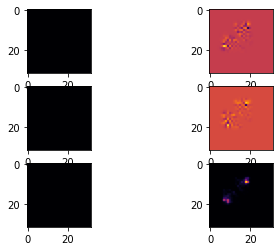

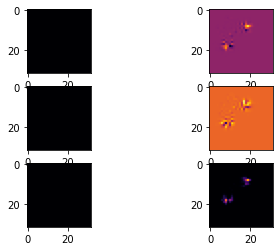

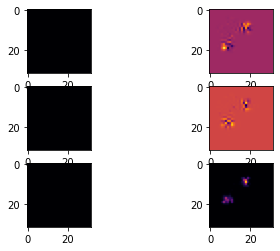

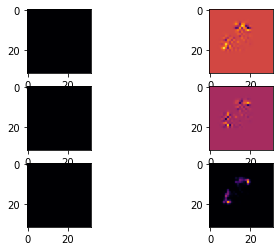

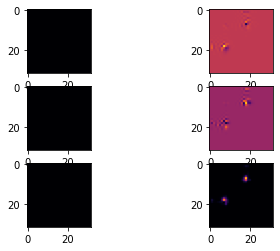

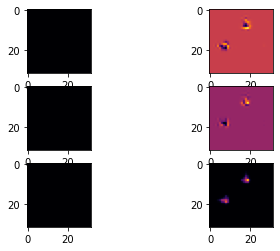

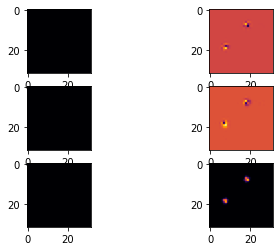

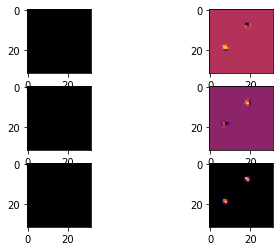

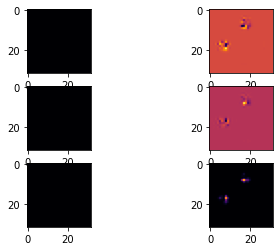

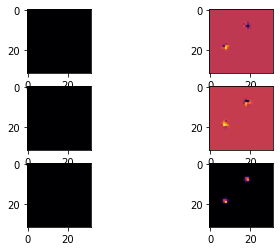

In [ ]:
model = SchrodingerModule()
# Move the model to GPU
model.to(torch_device)

# You may want to tune these hyperparameters to get better performance
optimizer = optim.AdamW(model.parameters(), lr=1e-6, betas=(0.9, 0.95), weight_decay=0.0)

total_steps = 0
num_epochs = 2
train_logfreq = 100

losses = []
all_val_loss = []
best_val_loss = float('inf')

predicted_frame = None
true_frame = None
difference_frame = None

epoch_iterator = trange(num_epochs)
for epoch in epoch_iterator:
    # Train
    data_iterator = tqdm(trainloader)
    for x, y in data_iterator:
        total_steps += 1
        x = x.to(torch_device)
        y = y.to(torch_device)
        prediction = model(x[0])
        # print(prediction.shape)
        # print(y.shape)
        loss = nn.MSELoss()(prediction, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        data_iterator.set_postfix(loss=loss.item())
        if total_steps % train_logfreq == 0:
            losses.append(loss.item())

    # Validation
    val_loss = []
    model.eval()
    i = 0
    for x, y in testloader:
        x, y = x.to(torch_device), y.to(torch_device)
        with torch.no_grad():
          loss = nn.MSELoss()(prediction, y)
          predicted_frame = prediction
          true_frame = y
          difference_frame = y - prediction
          if i % 100 == 0:
            compare_frames(prediction.cpu().detach().numpy()[0], true_frame.cpu().detach().numpy()[0]) # Dataviz
          val_loss.append(loss.item())
        i += 1
    model.train()

    all_val_loss.append(np.mean(val_loss))
    # Save best model
    if np.mean(val_loss) < best_val_loss:
        best_val_loss = np.mean(val_loss)

    epoch_iterator.set_postfix(val_loss=np.mean(val_loss), best_val_loss=best_val_loss)

    # Periodically save model
    torch.save(model.state_dict(), os.path.join(root_folder, "trained_conv_encoder.pt"))


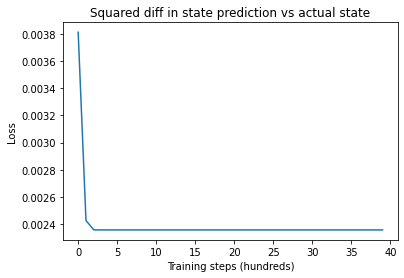

Text(0.5, 0, 'epochs (2000 training steps)')

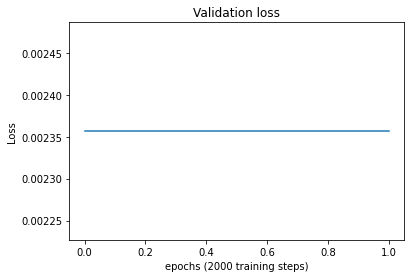

In [ ]:
from matplotlib import pyplot as plt
plt.plot(losses)
plt.title('Squared diff in state prediction vs actual state')
plt.ylabel('Loss')
plt.xlabel('Training steps (hundreds)')
plt.show()
plt.plot(all_val_loss)
plt.title('Validation loss')
plt.ylabel('Loss')
plt.xlabel('epochs (2000 training steps)')


# RNN sequence-to-sequence model with LSTM implementation
For every batch, we can try to use the first 20 frames to predict the next 20 frames of the simulation. At first glance, because we are not trying to make predictions many frames into the future, an LSTM seems like a viable fit for the project because it is below 100 timesteps. However, there exists pitfalls with this approach specifically described in the project write-up: The starting potential function is very important and even with an LSTM, a lot of information could be lost and first few steps of the model (which are very crucial) may not learn much at all.

In [ ]:
# Hyperparameters
input_size_encoder = 128 * 128
input_size_decoder = 128 * 128
encoder_embedding_size = 300
encoder_embedding_size = 300
hidden_size = 1024
num_layers = 1
enc_dropout = 0.0
dec_dropout = 0.0

batch_size = 100
num_epochs = 1
learning_rate = 1e-4

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, embbed_dim, num_layers=1):
        super(Encoder, self).__init__()

        # set the encoder input dimesion , embbed dimesion, hidden dimesion, and number of layers 
        self.input_dim = input_dim
        self.embbed_dim = embbed_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # initialize the embedding layer with input and embbed dimention
        self.embedding = nn.Embedding(input_dim, self.embbed_dim)

        # intialize the LSTM to take the input dimetion of embbed, and output dimention of hidden and
        # set the number of LSTM layers
        self.lstm = nn.LSTM(self.embbed_dim, self.hidden_dim, num_layers=self.num_layers)
              
    def forward(self, src):
        embedded = self.embedding(src).view(1,1,-1)
        outputs, hidden = self.lstm(embedded)
        return outputs, hidden

class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, embbed_dim, num_layers):
        super(Decoder, self).__init__()

        # set the encoder output dimension, embed dimension, hidden dimension, and number of layers 
        self.embbed_dim = embbed_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers

        # initialize every layer with the appropriate dimension. For the decoder layer, it will consist of an embedding, lstm, a Linear layer and a Log softmax activation function.
        self.embedding = nn.Embedding(output_dim, self.embbed_dim)
        self.lstm = nn.LSTM(self.embbed_dim, self.hidden_dim, num_layers=self.num_layers)
        self.out = nn.Linear(self.hidden_dim, output_dim)
        self.softmax = nn.LogSoftmax(dim=1)
      
    def forward(self, input, hidden):

        # reshape the input to (1, batch_size)
        input = input.view(1, -1)
        embedded = F.relu(self.embedding(input))
        output, hidden = self.lstm(embedded, hidden)       
        prediction = self.softmax(self.out(output[0]))
      
        return prediction, hidden

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
      
        # initialize the encoder and decoder
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
     
    def forward(self, source, target, teacher_forcing_ratio=0.5):

        input_length = source.size(0) # get the input length (number of frames)
        batch_size = target.shape[1] 
        target_length = target.shape[0]
        vocab_size = self.decoder.output_dim
      
        # initialize a variable to hold the predicted outputs
        outputs = torch.zeros(target_length, batch_size, vocab_size).to(self.device)

        # encode every frame in the video
        for i in range(input_length):
            encoder_output, encoder_hidden = self.encoder(source[i])

        # use the encoder’s hidden layer as the decoder hidden
        decoder_hidden = encoder_hidden.to(device)
  
        # add a token before the first predicted word
        decoder_input = torch.tensor([SOS_token], device=device)  # SOS

        # topk is used to get the top K value over a list
        # predict the output word from the current target word. If we enable the teaching force,  then the #next decoder input is the next word, else, use the decoder output highest value. 

        for t in range(target_length):   
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            outputs[t] = decoder_output
            teacher_force = random.random() < teacher_forcing_ratio
            topv, topi = decoder_output.topk(1)
            input = (target[t] if teacher_force else topi)
            if(teacher_force == False and input.item() == EOS_token):
                break
        return outputs

NameError: ignored

In [ ]:
# Training the Seq2Seq
optimizer = optim.Adam(seq2seq.parameters())
criterion = nn.MSELoss()

def trainSeq2Seq(seq2seq, iterator, optimizer, criterion):
    seq2seq.train()
    epoch_loss = 0
    for batchIndex in range(10):
        # data = np.load("big_data_5.npy")
        batchName = "big_data_" + str(batchIndex) + ".npy"
        currentBatch = np.load(batchName)
        inputs = currentBatch[:, :21, :, :, :]
        outputs = currentBatch[:, 21:41, :, :, :]
        predictions = seq2seq(currentBatch)
        loss = criterion(output, predictions)
        loss.backward()
        optimizer.step()
    return epoch_loss / (i + 1)